<a href="https://colab.research.google.com/github/efti-nile/solafune/blob/main/Solafune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imagecodecs

# Imports

In [2]:
from pathlib import Path
import os
import shutil
import json

from pprint import pprint
import numpy as np
from scipy import stats
import tifffile
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Load Data

In [3]:
%cd /content

data_root = "/content/drive/MyDrive/Solafune"

# Test
![ ! -f test_images.zip ] && cp $data_root/test_images.zip .
![ ! -d test ] && unzip -q test_images.zip -d test

# Train
![ ! -f train_images.zip ] && cp $data_root/train_images.zip .
![ ! -d train ] && unzip -q train_images.zip -d train
!cp $data_root/train_annotation.json train

# Sample
!cp $data_root/sample.json .

/content


# Explore Single Image

In [4]:
img_path = Path('train/images/train_0.tif')
img = tifffile.imread(img_path)
type(img), img.dtype, img.shape, img.nbytes // 2**20

(numpy.ndarray, dtype('float64'), (804, 981, 12), 72)

In [5]:
for i in range(img.shape[2]):
    print(f"Channel {i}")
    print(stats.describe(img[:, :, i].flatten()))

Channel 0
DescribeResult(nobs=788724, minmax=(220.5, 1793.5), mean=477.0197574922703, variance=12887.837943714669, skewness=1.3753871173595769, kurtosis=6.750886438398968)
Channel 1
DescribeResult(nobs=788724, minmax=(133.5, 5266.0), mean=574.1639349571194, variance=38897.91685733301, skewness=3.136572992141515, kurtosis=24.158414737941385)
Channel 2
DescribeResult(nobs=788724, minmax=(176.0, 5774.0), mean=876.9985663685243, variance=50507.0495699115, skewness=2.9558250464916918, kurtosis=21.383018741290147)
Channel 3
DescribeResult(nobs=788724, minmax=(170.0, 5944.0), mean=1008.042801760557, variance=123814.54604604264, skewness=1.492501012737036, kurtosis=5.7870980128160845)
Channel 4
DescribeResult(nobs=788724, minmax=(182.5, 5036.0), mean=1518.4334695947114, variance=75880.01300353066, skewness=1.2958632628273348, kurtosis=7.202203197314082)
Channel 5
DescribeResult(nobs=788724, minmax=(85.5, 5088.5), mean=2500.5449341660183, variance=154519.85625722265, skewness=1.2177123591983794

In [6]:
anns = json.load(open('train/train_annotation.json'))

In [7]:
def get_segs(anns, file_name):
    for objs in anns['images']:
        if objs['file_name'] == file_name:
            segs = [obj['segmentation'] for obj in objs['annotations']]
            return segs

In [8]:
segs = get_segs(anns, 'train_0.tif')
len(segs)

671

In [9]:
import matplotlib.patches as patches
import random

def plot_channels_with_polygons(image, polygons, max_columns=3, dropout=0.0, polygon_color='red'):
    """
    Plots all channels of a numpy ndarray as greyscale images and draws polygons on them
    with a certain dropout probability.

    Args:
        image: A numpy ndarray of shape (width, height, channels).
        polygons: A list of polygons, where each polygon is a list of (x, y) tuples.
        max_columns: Maximum number of channels to plot in a row.
        dropout: Probability of not plotting a polygon (between 0 and 1).
        polygon_color: Color of the polygons.
    """
    num_channels = image.shape[2]
    num_rows = (num_channels + max_columns - 1) // max_columns

    fig, axes = plt.subplots(num_rows, max_columns, figsize=(4 * max_columns, 4 * num_rows))

    for i in range(num_channels):
        row = i // max_columns
        col = i % max_columns
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image[:, :, i], cmap='gray')

        # Draw polygons with dropout
        for polygon in polygons:
            if random.random() >= dropout:
                patch = patches.Polygon(polygon, closed=True, fill=False,
                                        edgecolor=polygon_color, linewidth=1, alpha=0.7)
                ax.add_patch(patch)

        ax.set_title(f"Channel {i}")
        ax.axis('off')

    # Remove any unused subplots
    for i in range(num_channels, num_rows * max_columns):
        row = i // max_columns
        col = i % max_columns
        ax = axes[row, col] if num_rows > 1 else axes[col]
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [10]:
def convert_to_tuples(coordinates):
  """
  Converts a flat list of coordinates to a list of tuples.

  Args:
    coordinates: A list of coordinates in the format [x1, y1, x2, y2, ...].

  Returns:
    A list of tuples representing the coordinates [(x1, y1), (x2, y2), ...].
  """
  return [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]

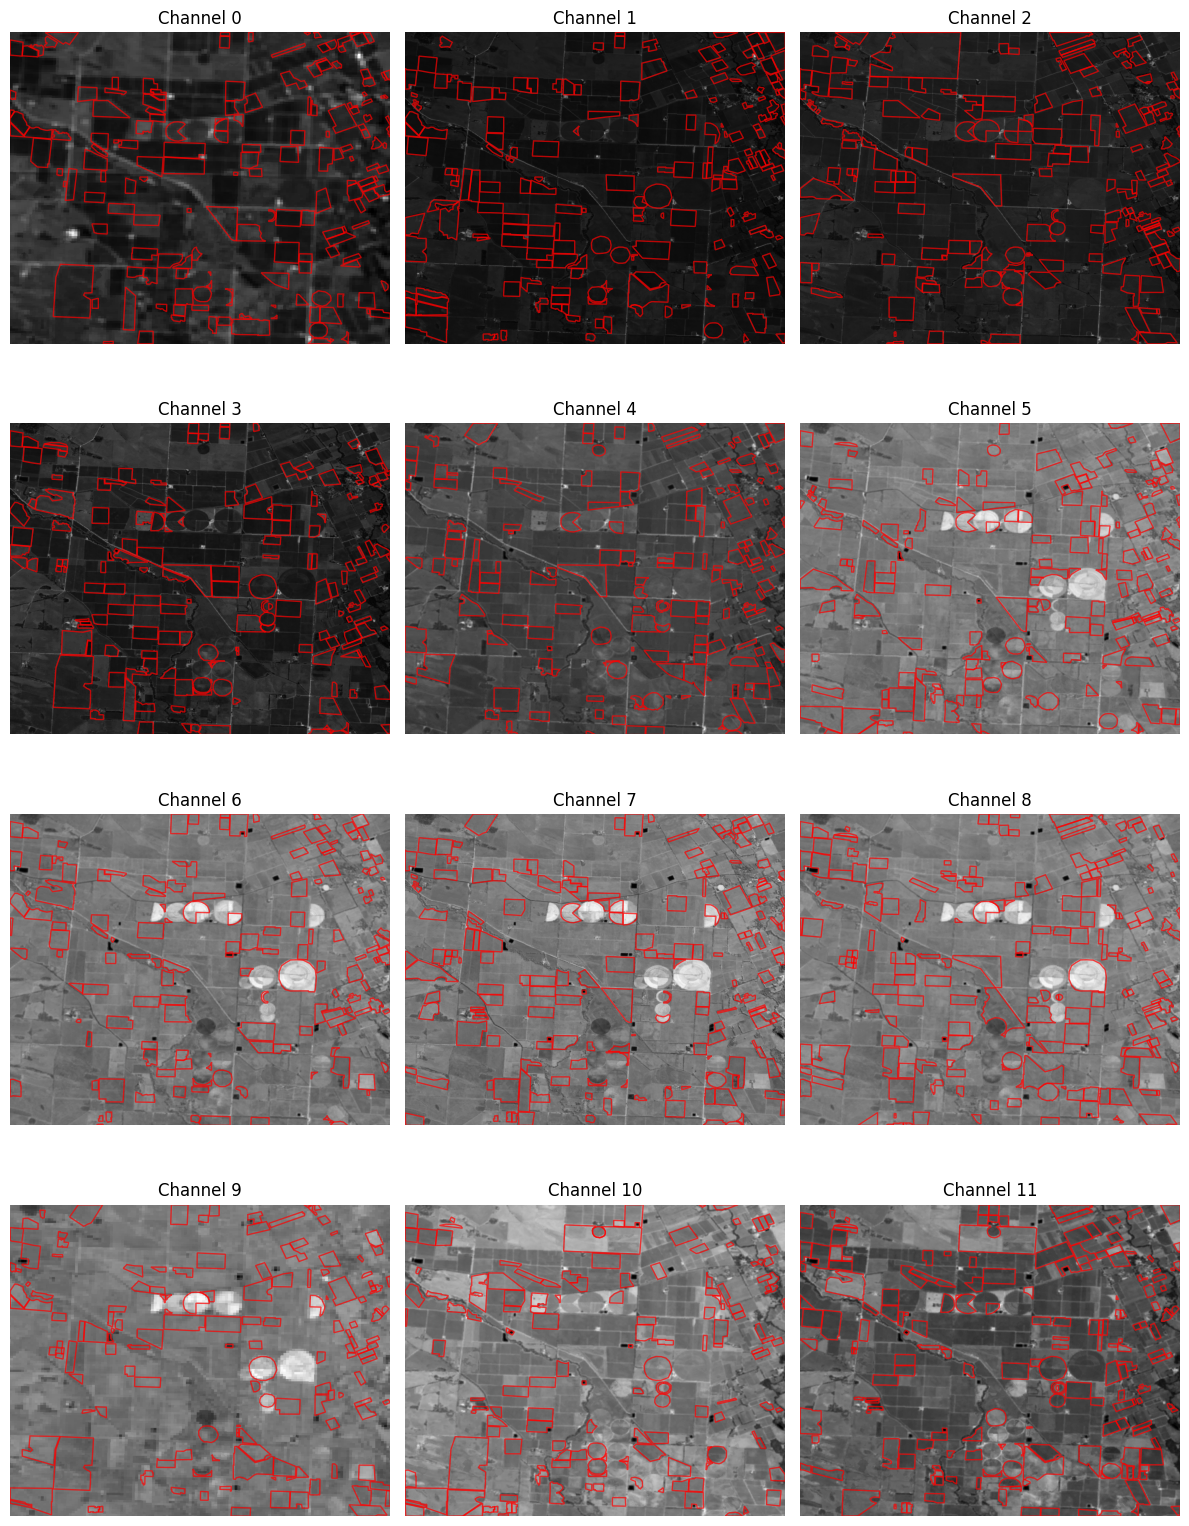

In [11]:
polys = [convert_to_tuples(seg) for seg in segs]
plot_channels_with_polygons(img, polys, dropout=.75)

In [12]:
def normalize(arr):
  """Normalizes a NumPy array to the range [0, 1]."""
  min_val = arr.min()
  max_val = arr.max()
  normalized_arr = (arr - min_val) / (max_val - min_val)
  return normalized_arr

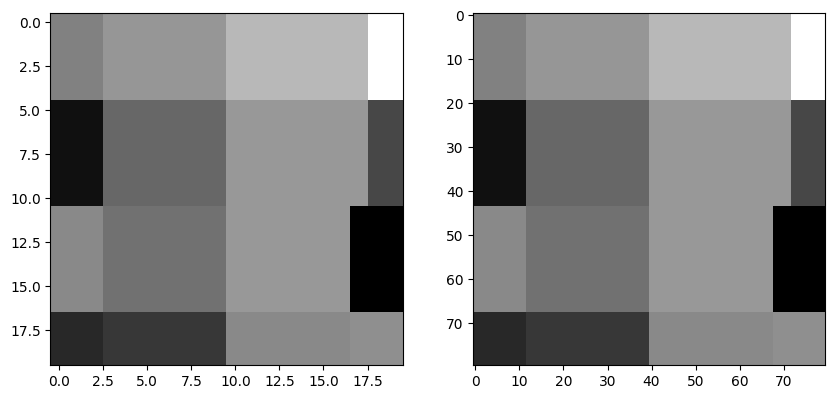

((3216, 3924, 3), dtype('uint8'))

In [13]:
import cv2
channel_idx = 0
channel = normalize(img[:, :, channel_idx]).copy()
# assert not np.may_share_memory(channel, img)
# normalize(channel).dtype
f = 4
channel_up = cv2.resize(channel, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_NEAREST)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(channel[:20, :20], cmap='gray')
axes[1].imshow(channel_up[:20*f, :20*f], cmap='gray')
plt.show()
# Set up x and y range exectly to 0..20 and 0..40
axes[0].set_xlim(0, 20)
axes[0].set_ylim(0, 20)
axes[1].set_xlim(0, 20*f)
axes[1].set_ylim(0, 20*f)
# convert channel_up to uint8
channel_up = (channel_up * 255).astype(np.uint8)
# convert channel_up to greyscale
channel_up = cv2.cvtColor(channel_up, cv2.COLOR_GRAY2RGB)
channel_up.shape, channel_up.dtype

In [14]:
import cv2
import numpy as np

def draw_polygons_on_image(image, polygons, color=(0, 255, 0), thickness=1, factor=1.0):
    """
    Draws polygons on a copy of the given image, with a scaling factor for coordinates.

    Args:
        image: An OpenCV uint8 image.
        polygons: A list of polygons, where each polygon is a list of (x, y) tuples.
        color: The color of the polygons (default is green).
        thickness: The thickness of the polygon lines (default is 2).
        factor: The scaling factor for the polygon coordinates.

    Returns:
        A copy of the image with the polygons drawn on it.
    """

    image_copy = image.copy()
    for polygon in polygons:
        # Scale polygon points
        scaled_polygon = [(int(x * factor), int(y * factor)) for x, y in polygon]

        # Convert scaled polygon points to a NumPy array of integers
        pts = np.array(scaled_polygon, np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Draw the polygon on the image copy
        cv2.polylines(image_copy, [pts], isClosed=True, color=color, thickness=thickness)

    return image_copy

In [15]:
channel_up_ann = draw_polygons_on_image(channel_up, polys, thickness=1,
                                        factor=4.)
cv2.imwrite('channel_up_ann.jpg', channel_up_ann)
# plt.imshow(channel_up_ann)

True

In [16]:
!pip3 install torch torchvision

In [18]:
import torch